In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats.mstats import winsorize
from scipy import optimize
from sklearn import preprocessing
#from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from datetime import datetime, date, time

In [2]:
# seconds between two datetime
def date_diff(dInit, dFin):
    return (datetime.fromisoformat(dFin) - datetime.fromisoformat(dInit)).total_seconds()

# days between two datetime. does not consider specific time
def date_diff_days(dInit, dFin):
    return ((datetime.fromisoformat(dFin)).date() - (datetime.fromisoformat(dInit)).date() ).days

# week day (Mon-Sun, 0-6)
def date_weekday(date):
    return datetime.fromisoformat(date).weekday()

# only the hours not minutes and seconds
def date_hour(date):
    return datetime.fromisoformat(date).hour

# how many times each hashed code is in the dataframe
def hash_to_occurrences(dataframe, column):
    dic = (dataframe[column].value_counts()).to_dict()
    return dataframe[column].map(dic, na_action="ignore")

# for each feature in dataframe, print num of unique elements, num of duplicates not NaN, num of NaN
def information(data):
    
    print("{0:30} {1:13} {2:10} {3:15}".format ("Column", "len(set(el))", "len(duplicates ", "len(nulls)"))
    print("{0:30} {1:13} {2:10} {3:15}".format ("      ", "            ", "      non-null)", "          "))
    print("{0:30} {1:13} {2:10} {3:15}".format ("------", "------------", "---------------", "----------"))

    for i, e in enumerate(data.columns):
        lst = data[e]
        el_set = set()
        el_duplicates_n = 0
        el_null_n = 0

        for x in lst:
            if pd.isnull(x):
                el_null_n += 1
            else:
                if x in el_set:
                    el_duplicates_n += 1
                else:
                    el_set.add(x)

        print("{0:30} {1:13} {2:10} {3:15}".format (e, len(el_set), el_duplicates_n, el_null_n))

#TODO change name with bigger_than_threshold        
def predict_with_threshold(p, thresh):
    if p >= thresh:
        return 1
    else:
        return 0
        
# given a model, X and a threshold, return Y 
def predicted_y_with_threshold(model, X_cross_val, thresh):
    predicted_y_prob = model.predict_proba(X_cross_val)
    predicted_y_prob_1 = predicted_y_prob[:,1]
    thresh_vec = [thresh]*len(predicted_y_prob_1)
    return list(map(predict_with_threshold, predicted_y_prob_1, thresh_vec))


# given c_th = (c, threshold) fit a LogisticRegression on train set 
#     then return corresponding F1 score for cross validation set
#TODO do not hardcode LogisticRegression, do not use global variables (X, Y)_(train, cross_val)
def f1_score_neg(c_th):
    model = LogisticRegression(class_weight="balanced", C=c_th[0])
    model.fit(X_train, Y_train)
    Y_pred = predicted_y_with_threshold(model, X_cross_val,c_th[1])
    f1_neg = -1 * f1_score(Y_cross_val, Y_pred)
    return f1_neg

# given c_th = (c, threshold) fit a LogisticRegression on train set 
#     then return a _modified_ F1 score for cross validation set
#TODO do not use global variables
def f1_score_neg_mod_th(c_th):
    model = LogisticRegression(class_weight="balanced", C=c_th[0])
    model.fit(X_train, Y_train)
    Y_pred = predicted_y_with_threshold(model, X_cross_val,c_th[1])
    Y_pred_series = pd.Series(list(Y_pred))
    
    f1_mod_neg = -1*f1_mod(Y_cross_val_series, Y_pred_series)
    return f1_mod_neg


#modified F1_score for cross validation set
def f1_mod(Y_cross_val_series, Y_pred_series):
    
    tp = ((Y_pred_series == 1) & (Y_cross_val_series == 1)).sum() 
    fp = ((Y_pred_series == 1) & (Y_cross_val_series == 0)).sum()
    fn = ((Y_pred_series == 0) & (Y_cross_val_series == 1)).sum() 
    
    precision = tp/(tp+fp)
    recall_mod = (tp/(tp+fn))**(4)

    f1_mod = 2*precision*recall_mod/(precision+recall_mod)
    return f1_mod
    

In [3]:
dataset = pd.read_csv("sample_dataset_data_scientist.csv")

In [4]:
data = dataset.copy()

In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202389 entries, 0 to 202388
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Transaction_Id        202389 non-null  int64  
 1   Merchant_Id           202389 non-null  int64  
 2   TxnInitTime           202389 non-null  object 
 3   TxnCompleteTime       202389 non-null  object 
 4   ClientIP              202389 non-null  object 
 5   User_Id               202389 non-null  object 
 6   CountryCode           202389 non-null  int64  
 7   Price                 202389 non-null  float64
 8   ChannelType           202389 non-null  int64  
 9   Alpha2Code            202389 non-null  object 
 10  GeoIpCountry          202009 non-null  object 
 11  UserAgent             202389 non-null  object 
 12  Email_Id              101668 non-null  object 
 13  FirstTransactionDate  202389 non-null  object 
 14  UniquePaymentChannel  202389 non-null  int64  
 15  

In [6]:
information(data)

Column                         len(set(el))  len(duplicates  len(nulls)     
                                                   non-null)                
------                         ------------  --------------- ----------     
Transaction_Id                        202389          0               0
Merchant_Id                              259     202130               0
TxnInitTime                           196141       6248               0
TxnCompleteTime                       195996       6393               0
ClientIP                              157313      45076               0
User_Id                               136903      65486               0
CountryCode                                7     202382               0
Price                                    563     201826               0
ChannelType                                3     202386               0
Alpha2Code                                 7     202382               0
GeoIpCountry                              39     

In [7]:
#find redundant columns

for idx1, e1 in enumerate(data.columns):
    for idx2, e2 in enumerate(data.columns):
        if idx2 <= idx1:
            continue
        else:
            if len(data[e1].unique()) != len(data[e2].unique()):
                continue
            else:
                relations = []
                for el_col1, el_col2 in zip(data[e1], data[e2]):
                    if [el_col1, el_col2] not in relations:
                        relations.append([el_col1, el_col2])
                        if len(relations) > len(data[e1].unique()):
                            break
                if len(relations) == len(data[e1].unique()) == len(data[e2].unique()):
                    print(e1, "and", e2, "are redundant. The relation is", relations)
                
            

CountryCode and Alpha2Code are redundant. The relation is [[356, 'IN'], [458, 'MY'], [360, 'ID'], [702, 'SG'], [608, 'PH'], [116, 'KH'], [764, 'TH']]


In [8]:
#delete countrycode. Alphacode to be checked against GeoIpCountry
data.drop(columns=["CountryCode"], inplace = True)

print(data.shape)

(202389, 18)


In [9]:
# check that TxnInitTime is smaller than TxnCompleteTime
(data.TxnInitTime <= data.TxnCompleteTime).all()

True

In [10]:
# check that FirstTransactionDate is smaller or equal than TxnCompleteTime
(data.FirstTransactionDate <= data.TxnCompleteTime).all()

True

In [11]:
#Note: FirstTransactionDate is correctly recorded when transaction is completed
print((data.FirstTransactionDate <= data.TxnInitTime).all())
print(sum(data.TxnInitTime < data.FirstTransactionDate))
data[data.TxnInitTime < data.FirstTransactionDate]

False
8


,Transaction_Id,Merchant_Id,TxnInitTime,TxnCompleteTime,ClientIP,User_Id,Price,ChannelType,Alpha2Code,GeoIpCountry,UserAgent,Email_Id,FirstTransactionDate,UniquePaymentChannel,FirstEmailDate,Flag,PaymentChannel,ItemName
53558,53559,2540,2021-07-19 23:59:53,2021-07-20 00:00:37,24e94c1cafec6abf09be004c6f70ae6c5f754c4c8b2553...,5096390c0f41b1069c821aa13e2ea6d189a2c347af373d...,800.00,2,IN,IN,Mozilla/5.0 (Linux; Android 11; SM-M215F) Appl...,780f6b6f7accb06a89eb2670242db359a6947ee81e6bc4...,2021-07-20,1,2021-07-20,0,PaymentChannel 1,Item 1
102641,102642,2216,2021-06-17 23:59:11,2021-06-18 00:00:21,a59992fc4edc2923e045122dbc44fbf4bdf4f44c3302d2...,08c908f42df2c12e61694e333b0cddd41028616eb13f28...,50.00,6,PH,PH,Mozilla/5.0 (Linux; Android 11; SAMSUNG SM-N97...,987ca8527aa52bd9a5ade92b426723d302e6f4442be3b3...,2021-06-18,1,2021-06-18,0,PaymentChannel 7,Item 49
104116,104117,4767,2021-06-27 23:59:51,2021-06-28 00:06:26,957400f4af9d05a507efa0431cd7e03f53754978be2c1a...,4566c10987518b78d401afb93ce8de141328a18a0e004c...,530.00,6,PH,PH,Mozilla/5.0 (Linux; Android 10; CPH1823) Apple...,4566c10987518b78d401afb93ce8de141328a18a0e004c...,2021-06-28,1,2021-06-28,0,PaymentChannel 7,Item 41
115427,115428,4768,2021-06-02 23:58:59,2021-06-03 00:00:36,b269b4f8d91751f46329b8f9b8465d1af83eaa088af069...,a864bb890e0fec489337b68d0474974bc4c35272780ee6...,214.00,6,MY,MY,Mozilla/5.0 (Linux; Android 8.1.0; CPH1901) Ap...,a864bb890e0fec489337b68d0474974bc4c35272780ee6...,2021-06-03,1,NaN,0,PaymentChannel 4,Item 29
138044,138045,1211,2021-05-12 23:56:39,2021-05-13 00:02:41,f90040280c419492cdf1979e05720e5c405d97e17f6d75...,85c21bf1d9cb312342ecfa8e739a007c6477a79cc679bb...,200.00,6,PH,PH,Mozilla/5.0 (Linux; Android 10; JNY-LX2; HMSCo...,af297724f4cb6b9d77b01cd1fa408a6570e23daf0c40f7...,2021-05-13,2,2020-06-19,0,PaymentChannel 7,Item 23
165033,165034,1833,2021-05-09 23:58:43,2021-05-10 00:01:09,e6d1407e077e57414b0eb268d2a3548bf267cd57747c49...,5fa77d50abbc8b5bc8bbf93bef801577c32370a49bec05...,29.10,6,KH,KH,Mozilla/5.0 (Linux; Android 10; SM-G965F) Appl...,3d969c39de949ca16c775ecd708c498e99b547ed086ce2...,2021-05-10,2,2021-05-10,0,PaymentChannel 8,Item 23
180847,180848,4767,2021-06-25 23:58:46,2021-06-26 00:02:52,481eb7a27c445c32200c44d8cd4d7e7be3d211484a58cb...,380466ecc597422593b4272c9bbc023879e33338304713...,530.00,6,PH,PH,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,380466ecc597422593b4272c9bbc023879e33338304713...,2021-06-26,1,2020-07-26,0,PaymentChannel 7,Item 41
193707,193708,1213,2021-05-12 23:59:17,2021-05-13 00:00:43,8c5c51cc6366124410712b7bdee09faee03630aecfe62c...,d75fe2cf3dff3b32d4cdfb92a547fa64741ece4af0844b...,23.77,6,MY,MY,Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like...,ba71359c860e194f6c91694d2f945a9eb3011fe1d8ad60...,2021-05-13,2,2021-04-03,0,PaymentChannel 4,Item 23


In [12]:
# check that FirstTransactionDate is smaller or equal than 2022-02-21 (when data is downloaded)
(data.FirstTransactionDate <= "2022-02-21").all()

True

In [14]:
# set appropriate type
data = data.astype(
    {"Merchant_Id":"category", 
     "ChannelType":"category", 
     "UserAgent":"category", 
     "PaymentChannel":"category", 
     "ItemName":"category"}) 

# strings to numbers
data["Merchant_Id"] = data["Merchant_Id"].cat.codes
data["ChannelType"] = data["ChannelType"].cat.codes
data["UserAgent"] = data["UserAgent"].cat.codes
data["PaymentChannel"] = data["PaymentChannel"].cat.codes
data["ItemName"] = data["ItemName"].cat.codes
#Alpha2Code and GeoIpCountry need same codes. Done later

In [15]:
# Fix NaN and add features

In [16]:
# where there is Email_Id but not FirstEmailDate, substitute FirstEmailDate with FirstTransactionDate
data.loc[ (~pd.isna(data.Email_Id)) & pd.isna(data.FirstEmailDate), "FirstEmailDate"] = data.loc[ (~pd.isna(data.Email_Id)) & pd.isna(data.FirstEmailDate), "FirstTransactionDate"]

In [17]:
# part of the day the transaction is complete. Devide day in 24 categories according to hour
data.insert(4, "TxnHour", list(map(date_hour, data["TxnCompleteTime"]))  )

In [18]:
#duration duration
data.insert(5, "TxnDuration_Seconds", list( map(date_diff, data["TxnInitTime"], data["TxnCompleteTime"]) )  )

data["TxnDuration_Seconds"] = data["TxnDuration_Seconds"].astype(int)

In [ ]:
#weekday (0-6) in which the transaction has been made
data.insert(6, "TxnWeekday", list(map(date_weekday, data["TxnCompleteTime"])))

#days from the first transaction
data.insert(7, "FromFirstTxnToCurrentTxn_Days", list(map(date_diff_days, data["FirstTransactionDate"], data["TxnCompleteTime"])) )

#number of transactions from IP
data.insert(9, "ClientIP_occurrences", hash_to_occurrences(data, "ClientIP") )

#number of transactions of a user for a specific digital service 
data.insert(11, "User_Id_occurrences", hash_to_occurrences(data, "User_Id") )

#GeoIp info does not coincide with Alpha2Code info
data.insert(16, "GeoIpNotEqAlpha2", ( ~( (data.GeoIpCountry == data.Alpha2Code) | pd.isnull(data.GeoIpCountry) ) ).astype(int) )

#number of transactions done with a given email
data.insert(19, "Email_Id_occurrences", hash_to_occurrences(data, "Email_Id") )

#email is entered after the first transaction
data.insert(21, "FirstTransactionWithoutEmail",~(data.FirstEmailDate <= data.FirstTransactionDate))
#same as 
#data.insert(21, "FirstTransactionWithoutEmail", (data.FirstTransactionDate < data.FirstEmailDate) | (pd.isnull(data.FirstEmailDate) ))

data["FirstTransactionWithoutEmail"] = data["FirstTransactionWithoutEmail"].astype(int)

In [26]:
#replace NaN with 0
data.GeoIpCountry.fillna(0, inplace=True)

data.Email_Id_occurrences.fillna(0, inplace=True)

In [27]:
#Alpha2Code and GeoIpCountry with same codes
data = data.astype(
    {"Alpha2Code":"category", 
     "GeoIpCountry":"category"}) 


geoIpCountry_dic =  pd.Series(data.GeoIpCountry.cat.codes.values, index=data.GeoIpCountry).to_dict()

data["GeoIpCountry"] = data["GeoIpCountry"].map(geoIpCountry_dic)

data["Alpha2Code"] = data["Alpha2Code"].map(geoIpCountry_dic)

In [28]:
# set appropriate type
data = data.astype({
    "Alpha2Code":"int", 
    "GeoIpCountry":"int", 
    "Email_Id_occurrences":"int"}) 

In [29]:
#add an interaction term
data["TxnDuration_X_UniquePaymentCh"] = data.TxnDuration_Seconds * data.UniquePaymentChannel

In [30]:
#delete unuseful features
data.drop(columns=[
    "Transaction_Id", 
    "TxnInitTime", 
    "TxnCompleteTime", 
    "ClientIP", 
    "User_Id", 
    "Email_Id", 
    "FirstTransactionDate", 
    "FirstEmailDate"], 
    inplace = True)

data.shape

(202389, 20)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202389 entries, 0 to 202388
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Merchant_Id                    202389 non-null  int16  
 1   TxnHour                        202389 non-null  int64  
 2   TxnDuration_Seconds            202389 non-null  int64  
 3   TxnWeekday                     202389 non-null  int64  
 4   FromFirstTxnToCurrentTxn_Days  202389 non-null  int64  
 5   ClientIP_occurrences           202389 non-null  int64  
 6   User_Id_occurrences            202389 non-null  int64  
 7   Price                          202389 non-null  float64
 8   ChannelType                    202389 non-null  int8   
 9   Alpha2Code                     202389 non-null  int64  
 10  GeoIpCountry                   202389 non-null  int64  
 11  GeoIpNotEqAlpha2               202389 non-null  int64  
 12  UserAgent                     

In [32]:
information(data)

Column                         len(set(el))  len(duplicates  len(nulls)     
                                                   non-null)                
------                         ------------  --------------- ----------     
Merchant_Id                              259     202130               0
TxnHour                                   24     202365               0
TxnDuration_Seconds                     1336     201053               0
TxnWeekday                                 7     202382               0
FromFirstTxnToCurrentTxn_Days            943     201446               0
ClientIP_occurrences                      68     202321               0
User_Id_occurrences                       47     202342               0
Price                                    563     201826               0
ChannelType                                3     202386               0
Alpha2Code                                 7     202382               0
GeoIpCountry                              40     

In [33]:
#outliers with Tukey's method
q1 = data.TxnDuration_Seconds.quantile(0.25)
q3 = data.TxnDuration_Seconds.quantile(0.75)
iqr = q3 - q1
low_lim = q1 - 2 * iqr
up_lim = q3 + 2 * iqr

#percentage of TxnDuration_Seconds outliers with flag 1 over all the flag 1, as in 
100* (((data.TxnDuration_Seconds < low_lim) | (data.TxnDuration_Seconds > up_lim )) & data.Flag).sum() / (data.Flag == 1).sum()

4.855588112180829

In [34]:
#many outliers with flag 1  -->  keep outliers and use Winsorize method

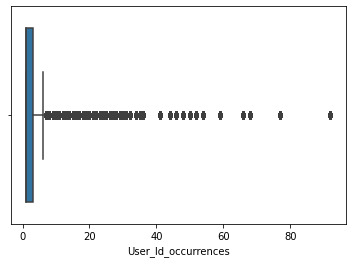

In [35]:
sns.boxplot(x = data.User_Id_occurrences)
plt.show()

In [36]:
winsorize(data.User_Id_occurrences, (0.01,0.01), inplace=True)

masked_array(data=[ 4, 23,  2, ...,  1,  1,  1],
             mask=False,
       fill_value=999999)

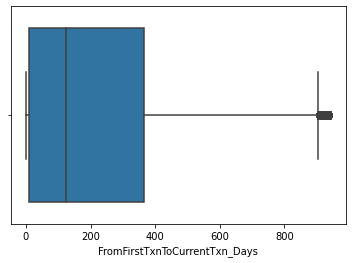

In [37]:
sns.boxplot(x = data.FromFirstTxnToCurrentTxn_Days)
plt.show()

In [38]:
winsorize(data.FromFirstTxnToCurrentTxn_Days, (0.01,0.01), inplace=True)

masked_array(data=[443,   2,  23, ..., 398, 709,  53],
             mask=False,
       fill_value=999999)

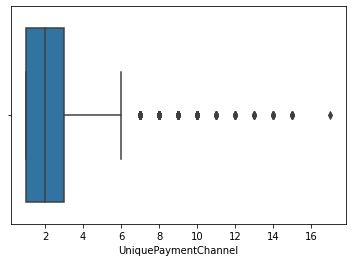

In [39]:
sns.boxplot(x = data.UniquePaymentChannel)
plt.show()

In [40]:
winsorize(data.UniquePaymentChannel, (0.01,0.01), inplace=True)

masked_array(data=[2, 1, 1, ..., 3, 3, 2],
             mask=False,
       fill_value=999999)

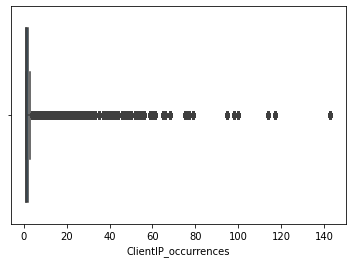

In [41]:
sns.boxplot(x = data.ClientIP_occurrences)
plt.show()

In [42]:
winsorize(data.ClientIP_occurrences, (0.01,0.01), inplace=True)

masked_array(data=[2, 7, 1, ..., 1, 3, 1],
             mask=False,
       fill_value=999999)

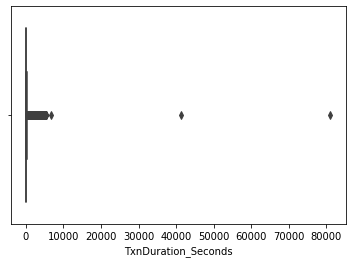

In [43]:
sns.boxplot(x = data.TxnDuration_Seconds)
plt.show()

In [44]:
winsorize(data.TxnDuration_Seconds, (0.01,0.01), inplace=True)

masked_array(data=[58, 43, 42, ..., 96, 47, 51],
             mask=False,
       fill_value=999999)

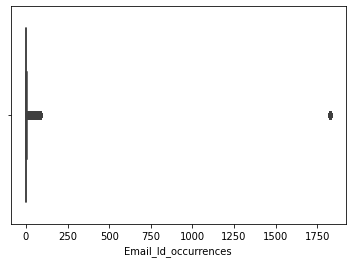

In [45]:
sns.boxplot(x = data.Email_Id_occurrences)
plt.show()

In [46]:
winsorize(data.Email_Id_occurrences, (0.01,0.01), inplace=True)

masked_array(data=[0, 0, 0, ..., 1, 0, 1],
             mask=False,
       fill_value=999999)

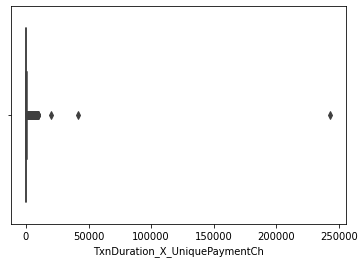

In [47]:
sns.boxplot(x = data.TxnDuration_X_UniquePaymentCh)
plt.show()

In [48]:
winsorize(data.TxnDuration_X_UniquePaymentCh, (0.01,0.01), inplace=True)

masked_array(data=[116,  43,  42, ..., 288, 141, 102],
             mask=False,
       fill_value=999999)

In [49]:
#set X and Y
X = data.drop(columns=['Flag'])
Y = data.Flag

In [50]:
#standardization

scaler = preprocessing.StandardScaler().fit(X)

X = scaler.transform(X) 

In [51]:
#divide data in 60% train, 20% cross validation, 20% test
X_train, X_cv_t, Y_train, Y_cv_t = train_test_split(X, Y, test_size=0.4, random_state=0)
X_cross_val, X_test, Y_cross_val, Y_test = train_test_split(X_cv_t, Y_cv_t, test_size=0.5, random_state=0)
del X_cv_t, Y_cv_t

In [52]:
#fit logistic regression with lambda = 1
model = LogisticRegression(class_weight="balanced")
model.fit(X_train, Y_train)

LogisticRegression(class_weight='balanced')

In [53]:
#predict vaues on test set using threshold =0.5
Y_test_pred_not_optimised = model.predict(X_test)

In [54]:
#model performance
Y_test_pred_not_optimised_series = pd.Series(list(Y_test_pred_not_optimised))
Y_test_series = pd.Series(list(Y_test))

print("Model performance with not optimised hyperparameters")
print("----------------------------------------------------")
#percentage of true positive
tp_not_optimised = ((Y_test_pred_not_optimised_series == 1) & (Y_test_series == 1)).sum() 
print("percentage of true positive", 100*tp_not_optimised/len(Y_test_series))
#percentage of false positive
fp_not_optimised = ((Y_test_pred_not_optimised_series == 1) & (Y_test_series == 0)).sum()
print("percentage of false positive", 100*fp_not_optimised/len(Y_test_series))
#percentage of false negative
fn_not_optimised = ((Y_test_pred_not_optimised_series == 0) & (Y_test_series == 1)).sum() 
print("percentage of false negative", 100*fn_not_optimised/len(Y_test_series))
#percentage of true negative
tn_not_optimised = ((Y_test_pred_not_optimised_series == 0) & (Y_test_series == 0)).sum() 
print("percentage of true negative", 100*tn_not_optimised/len(Y_test_series))
print("----------------------------------------------------")
print("number of true positive", tp_not_optimised)
print("number of false positive", fp_not_optimised)
print("number of false negative", fn_not_optimised)
print("number of true negative", tn_not_optimised)
print("----------------------------------------------------")
#F1 score for the test set with not optimised hyperparameters
precision_not_optimised = tp_not_optimised/(tp_not_optimised+fp_not_optimised)
recall_not_optimised = tp_not_optimised/(tp_not_optimised+fn_not_optimised)
print("F1 score", 2*precision_not_optimised*recall_not_optimised/(precision_not_optimised+recall_not_optimised) )

Model performance with not optimised hyperparameters
----------------------------------------------------
percentage of true positive 0.9239586936113444
percentage of false positive 11.211028212856366
percentage of false negative 0.25940016799248977
percentage of true negative 87.6056129255398
----------------------------------------------------
number of true positive 374
number of false positive 4538
number of false negative 105
number of true negative 35461
----------------------------------------------------
F1 score 0.138749768132072


In [66]:
#this cell takes about 2 minutes to compute
#maximise F1 score over C and thresholds hyperparameters
bnds = ((0, None), (0 , 1)) # ( (1/lambda bounds) , (threshold bounds) )
res = optimize.minimize(f1_score_neg, (1, 0.5), bounds=bnds, method='Powell')
print(res)

   direc: array([[1., 0.],
       [0., 1.]])
     fun: -0.3549060542797495
 message: 'Optimization terminated successfully.'
    nfev: 83
     nit: 2
  status: 0
 success: True
       x: array([2.86967657e+04, 9.48647669e-01])


datetime.timedelta(seconds=172, microseconds=254859)

In [56]:
#regularisation parameter C = lambda^(-1)
lambda_inv = res.x[0]

In [57]:
#threshold
threshold = res.x[1]

In [58]:
#Measure the model performance with optimised hyperparameters
model = LogisticRegression(class_weight="balanced", C=lambda_inv)
model.fit(X_test, Y_test)
Y_test_pred = predicted_y_with_threshold(model, X_test,threshold)

In [59]:
Y_test_pred_series = pd.Series(list(Y_test_pred))

print("Model performance with optimised hyperparameters")
print("------------------------------------------------")
#percentage of true positive
tp = ((Y_test_pred_series == 1) & (Y_test_series == 1)).sum() 
print("percentage of true positive", 100*tp/len(Y_test_series))
#percentage of false positive
fp = ((Y_test_pred_series == 1) & (Y_test_series == 0)).sum()
print("percentage of false positive", 100*fp/len(Y_test_series))
#percentage of false negative
fn = ((Y_test_pred_series == 0) & (Y_test_series == 1)).sum() 
print("percentage of false negative", 100*fn/len(Y_test_series))
#percentage of true negative
tn = ((Y_test_pred_series == 0) & (Y_test_series == 0)).sum() 
print("percentage of true negative", 100*tn/len(Y_test_series))
print("------------------------------------------------")
print("number of true positive", tp)
print("number of false positive", fp)
print("number of false negative", fn)
print("number of true negative", tn)
print("------------------------------------------------")
#F1 score for the test set with optimised hyperparameters
print("F1 score", f1_score(Y_test, Y_test_pred))

Model performance with optimised hyperparameters
------------------------------------------------
percentage of true positive 0.48915460250012355
percentage of false positive 0.9165472602401304
percentage of false negative 0.6942042591037106
percentage of true negative 97.90009387815604
------------------------------------------------
number of true positive 198
number of false positive 371
number of false negative 281
number of true negative 39628
------------------------------------------------
F1 score 0.37786259541984735


In [60]:
# just to check
precision = tp/(tp+fp)
recall = tp/(tp+fn)
2*precision*recall/(precision+recall) == f1_score(Y_test, Y_test_pred)

True

In [67]:
#this cell takes about 4 minutes to compute
#maximise the _modified_ F1 score over C and thresholds hyperparameters
Y_cross_val_series = pd.Series(list(Y_cross_val))
bnds1 = ((0, None), (0 , 1)) # ( (1/lambda bounds) , (threshold bounds) )
res1 = optimize.minimize(f1_score_neg_mod_th, (1, 0.5), bounds=bnds1, method='Powell')
print(res1)

   direc: array([[1.        , 0.        ],
       [0.09323149, 0.01141927]])
     fun: -0.1626183635599686
 message: 'Optimization terminated successfully.'
    nfev: 156
     nit: 3
  status: 0
 success: True
       x: array([3.81724847, 0.6505127 ])


datetime.timedelta(seconds=299, microseconds=86581)

In [62]:
#regularisation parameter C = lambda^(-1) with new optimisation
lambda_inv1 = res1.x[0]

In [63]:
#threshold with new optimisation
threshold1 = res1.x[1]

In [64]:
#test the model with new optimised hyperparameters
model = LogisticRegression(class_weight="balanced", C=lambda_inv1)
model.fit(X_test, Y_test)
Y_test_pred1 = predicted_y_with_threshold(model, X_test, threshold1)

In [65]:
Y_test_pred_series1 = pd.Series(list(Y_test_pred1))

print("Model performance with new optimised hyperparameters")
print("----------------------------------------------------")
#percentage of true positive
tp = ((Y_test_pred_series1 == 1) & (Y_test_series == 1)).sum() 
print("percentage of true positive", 100*tp/len(Y_test_series))
#percentage of false positive
fp = ((Y_test_pred_series1 == 1) & (Y_test_series == 0)).sum()
print("percentage of false positive", 100*fp/len(Y_test_series))
#percentage of false negative
fn = ((Y_test_pred_series1 == 0) & (Y_test_series == 1)).sum() 
print("percentage of false negative", 100*fn/len(Y_test_series))
#percentage of true negative
tn = ((Y_test_pred_series1 == 0) & (Y_test_series == 0)).sum() 
print("percentage of true negative", 100*tn/len(Y_test_series))
print("----------------------------------------------------")
print("number of true positive", tp)
print("number of false positive", fp)
print("number of false negative", fn)
print("number of true negative", tn)
print("----------------------------------------------------")
#F1 score for the test set
print("F1 score", f1_score(Y_test, Y_test_pred1))

Model performance with new optimised hyperparameters
----------------------------------------------------
percentage of true positive 0.8152576708335392
percentage of false positive 4.938485103018924
percentage of false negative 0.36810119077029496
percentage of true negative 93.87815603537724
----------------------------------------------------
number of true positive 330
number of false positive 1999
number of false negative 149
number of true negative 38000
----------------------------------------------------
F1 score 0.23504273504273507
